In [1]:
import pandas as pd
import numpy as np
#from sklearn.tree import DecisionTreeRegressor
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import skew
%matplotlib inline

In [2]:
train = pd.read_csv('price_data_tr.csv')
val = pd.read_csv('price_data_val.csv')
test = pd.read_csv('price_data_ts.csv')

In [3]:
train = train.drop(['id', 'date'], axis=1)
val = val.drop(['id', 'date'], axis=1)

val_x_col = list(val.columns)   # make a list of columns
val_x_col.remove('price')
val_y_col = ['price']

val_x_col, val_y_col

(['bedrooms',
  'bathrooms',
  'sqft_living',
  'sqft_lot',
  'floors',
  'waterfront',
  'view',
  'condition',
  'grade',
  'sqft_above',
  'sqft_basement',
  'yr_built',
  'yr_renovated',
  'zipcode',
  'lat',
  'long',
  'sqft_living15',
  'sqft_lot15'],
 ['price'])

In [69]:
import torch
train_x_df = pd.DataFrame(train, columns=val_x_col)
train_y_df = pd.DataFrame(train, columns=val_y_col)
val_x_df = pd.DataFrame(val, columns=val_x_col)
val_y_df = pd.DataFrame(val, columns=val_y_col)

train_x = torch.tensor(train_x_df.values, dtype=torch.float)
train_y = torch.tensor(train_y_df.values, dtype=torch.float)
val_x = torch.tensor(val_x_df.values, dtype=torch.float)
val_y = torch.tensor(val_y_df.values, dtype=torch.float)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

((torch.Size([12968, 18]), torch.Size([12968, 1])),
 (torch.Size([4323, 18]), torch.Size([4323, 1])))

In [70]:
train_x = (train_x - train_x.mean())/ train_x.std()
val_x = (val_x - val_x.mean())/ val_x.std()

In [27]:
#train_x_df.info()

In [19]:
#df_long = (train_x_df['long'] - train_x_df['long'].mean())/ train_x_df['long'].std()

In [26]:
#plt.scatter(np.log(df_long), train_y_df)

In [25]:
#plt.scatter((df_long), train_y_df)

In [28]:
# identify cat variables hidden as numerical
# convert categorical variables to dummy variables
# impute missing values using mean
# scale the data using power transformer
# log transform skewed features
  
def clean_train(train_to_clean):
    cont_vars = train_to_clean.select_dtypes(exclude="object").columns.values
    num_cat_vars = train_to_clean[cont_vars].loc[:,train_to_clean[cont_vars].nunique()<13].columns.values
    cont_vars = np.array([x for x in cont_vars.tolist() if x not in num_cat_vars.tolist()])

    skewd_feat = train_to_clean[cont_vars].apply(lambda x : skew(x,nan_policy='propagate'),axis=0)
    skewd_feat = skewd_feat[skewd_feat>0.7]
    train_to_clean[skewd_feat.index] = np.log1p(train_to_clean[skewd_feat.index])

    cat_vars = train_to_clean.select_dtypes(include="object").columns.values
    cat_vars = np.append(cat_vars,num_cat_vars)
    data_cat = pd.get_dummies(train_to_clean,columns=cat_vars)
    final = data_cat.set_index("Id")
    final = final.groupby(final.columns, axis = 1).transform(lambda x: x.fillna(x.mean())) 
    return final,skewd_feat
    
def clean_test(test_to_clean,transformed_train,skewd_feat):
    cont_vars = test_to_clean.select_dtypes(exclude="object").columns.values
    num_cat_vars = test_to_clean[cont_vars].loc[:,test_to_clean[cont_vars].nunique()<13].columns.values
    cont_vars = np.array([x for x in cont_vars.tolist() if x not in num_cat_vars.tolist()])
    test_to_clean[skewd_feat.index] = np.log1p(test_to_clean[skewd_feat.index])

    cat_vars = test_to_clean.select_dtypes(include="object").columns.values
    cat_vars = np.append(cat_vars,num_cat_vars)
    data_cat = pd.get_dummies(test_to_clean,columns=cat_vars)
    final = data_cat.set_index("Id")
    final = final.groupby(final.columns, axis = 1).transform(lambda x: x.fillna(x.mean()))
    final = final.T.reindex(index = transformed_train.columns.values).fillna(0).T
    return final

In [29]:
def fitRidgeCV(train_fit,target,**kwargs):
    train_y = target
    train_x = train_fit
    clf = RidgeCV(**kwargs)
    clf.fit(train_x,train_y)
    print("train loss:{}".format("test"))
    return clf

def predictLassoCV(test_fit,clf):
    return clf.predict(test_fit)

In [30]:

def fitLassoCV(train_fit,target,**kwargs):
    train_y = target
    train_x = train_fit
    clf = LassoCV(**kwargs)
    clf.fit(train_x,train_y)
    print("train loss:{}".format("test"))
    return clf

def predictLassoCV(test_fit,clf):
    return clf.predict(test_fit)

In [ ]:
#target = np.log1p(train_data["SalePrice"])
#train_cleaned,skewd_feat = clean_train(train_data.drop("SalePrice",axis=1))
#test_cleaned = clean_test(test_data,train_cleaned,skewd_feat)

In [57]:
ridge_alpha = [0.0001, 0.05, 0.1, 0.3, 1, 3, 5, 6,7,7.5,8,8.5,9,10,11,12, 15, 30, 50, 75,100]
#train_final = train_cleaned
train_final = train_x
#test_final = test_cleaned
test_final = val_x
#ridgeCV_model = fitRidgeCV(train_cleaned,target,normalize=False,alphas=ridge_alpha,store_cv_values = True)
ridgeCV_model = fitRidgeCV(train_final,train_y,normalize=False,alphas=ridge_alpha,store_cv_values = True)

train loss:test


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [58]:
lasso_alpha = [1, 0.5, 0.1, 0.02, 0.001, 0.0003,0.0004,0.0005]
#train_final = train_cleaned
#test_final = test_cleaned
lassoCV_model = fitLassoCV(train_x,train_y,cv=5, random_state=0,normalize=False,alphas=lasso_alpha)

c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233750407636797.06, tolerance: 135085666153.15668
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219811954346179.75, tolerance: 135085666153.15668
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coord

train loss:test


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.343e+14, tolerance: 1.699e+11
  model = cd_fast.enet_coordinate_descent(


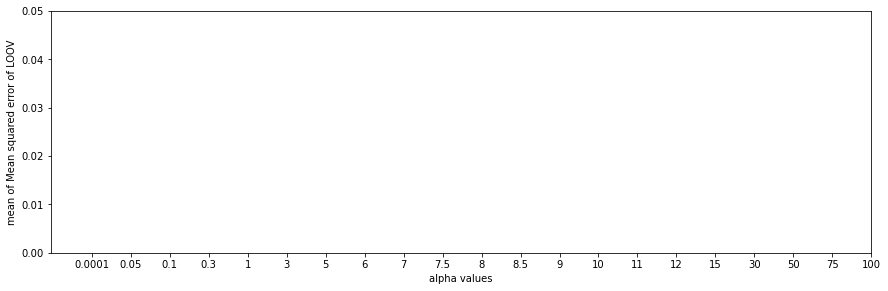

In [59]:
plt.plot(ridgeCV_model.cv_values_.mean(axis=0))
plt.xlabel("alpha values")
plt.ylabel("mean of Mean squared error of LOOV")
plt.ylim(0,0.05)
plt.xticks(range(1,len(ridge_alpha)+1),ridge_alpha)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=2.0, hspace=0.25,
                    wspace=0.35)
plt.show()

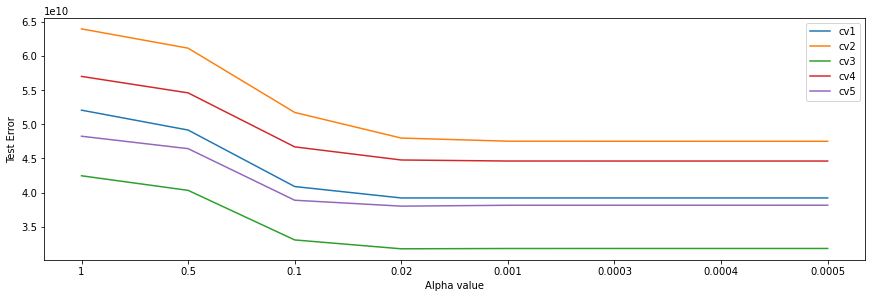

In [60]:
plt.plot(lassoCV_model.mse_path_)
plt.legend(["cv"+str(i) for i in range(1,lassoCV_model.mse_path_.shape[1]+1)])
plt.xticks(range(len(lasso_alpha)),lasso_alpha)
plt.xlabel("Alpha value")
plt.ylabel("Test Error")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=2.0, hspace=0.25,
                    wspace=0.35)
plt.show()

In [61]:
ridge_output = ridgeCV_model.predict(val_x)

In [62]:
lasso_output = lassoCV_model.predict(val_x)

In [63]:
#checking output
val_y = val_y.numpy()
count = 0
for i in range(len(ridge_output)):
    if (ridge_output[i] == val_y[i]):
        count += 1
        print(res[i])
print(count)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [64]:
#checking output
#val_y = val_y.numpy()
count = 0
for i in range(len(lasso_output)):
    if (lasso_output[i] == val_y[i]):
        count += 1
        print(res[i])
print(count)

0


In [65]:
lassoCV_model = fitLassoCV(train_x,train_y,cv=3, random_state=0,normalize=False,alphas=lasso_alpha)
lasso_output = lassoCV_model.predict(val_x)

c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171973166018147.94, tolerance: 107366948021.75932
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176127464513477.2, tolerance: 107366948021.75932
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordi

train loss:test


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.343e+14, tolerance: 1.699e+11
  model = cd_fast.enet_coordinate_descent(


In [66]:
#checking output
#val_y = val_y.numpy()
count = 0
for i in range(len(lasso_output)):
    if (lasso_output[i] == val_y[i]):
        count += 1
        print(lasso_output[i])
    print(lasso_output[i], val_y[i])
print(count)

-46748977.57070351 [453500.]
-46683289.48231125 [510000.]
-46666970.76265144 [379900.]
-46784329.72106171 [340000.]
-46859528.49114609 [273500.]
-46730778.62270355 [520000.]
-46695310.40673447 [430000.]
-46875473.33495903 [351358.]
-46408184.40537262 [1145000.]
-46748049.73718834 [328000.]
-47200521.4649601 [179900.]
-46904663.97068977 [280000.]
-46649637.097328186 [800000.]
-46455446.172288895 [574950.]
-46434920.07560158 [1050000.]
-46291145.23137283 [850000.]
-46505393.60303688 [555000.]
-46705149.8156929 [430000.]
-46778568.899793625 [522500.]
-46705880.68421936 [477000.]
-46756951.684869766 [273000.]
-46441998.60683823 [695000.]
-46657683.67121315 [655275.]
-46519777.25104904 [687500.]
-46673996.91378403 [515000.]
-45512973.6224556 [1700000.]
-46854959.94484329 [175000.]
-46370451.24943352 [890000.]
-46762020.71746254 [439000.]
-46755271.44594383 [329922.]
-45105223.635492325 [2479000.]
-47127280.75626564 [200000.]
-46375377.459825516 [779950.]
-46905678.105220795 [348000.]
-46922

-46919690.71461296 [360000.]
-46688125.02833557 [290000.]
-46498416.24277687 [625000.]
-46717634.02214432 [337000.]
-46747611.17087746 [551100.]
-46833632.61760712 [327000.]
-47078157.52860451 [286700.]
-46943477.65309143 [282000.]
-46632086.44447899 [569000.]
-46969809.99378204 [265000.]
-46876183.74698448 [245000.]
-46952010.82395363 [290750.]
-46554068.44495964 [303697.]
-46740117.63464928 [539950.]
-45996672.90325928 [1300000.]
-46529625.083631516 [447500.]
-46836346.06411743 [231500.]
-45964371.42123413 [1950000.]
-46708906.73899078 [300000.]
-46670655.26681137 [540000.]
-46846832.4738884 [310000.]
-46763375.39220619 [450000.]
-46419589.74666786 [448000.]
-46779266.486198425 [389000.]
-46491503.90044594 [950000.]
-46477515.4299736 [550000.]
-47012300.06344414 [280000.]
-46899425.36076546 [363000.]
-46809571.87677193 [430000.]
-46478769.45957184 [535000.]
-46673717.06305885 [574000.]
-46859190.612493515 [327500.]
-46826808.78913498 [355000.]
-46574959.03739548 [585000.]
-46594316.0

-46374008.568481445 [925000.]
-46411881.94528198 [478000.]
-46967555.79831123 [274950.]
-46183596.74803352 [748000.]
-46328980.39117432 [762500.]
-46608572.39314842 [515000.]
-46214260.54106903 [950000.]
-46168998.8779335 [1080000.]
-46723196.20241737 [320000.]
-46927847.0553112 [352900.]
-47006299.07633972 [335000.]
-46348980.76332855 [1085000.]
-46734357.40416336 [559500.]
-46509354.11479187 [392450.]
-46636805.3984108 [395000.]
-46774114.435497284 [339100.]
-46865932.985443115 [399950.]
-46601219.86367226 [453000.]
-46928131.98148918 [275000.]
-46634496.972558975 [450000.]
-46360798.69180298 [850000.]
-46751865.60424423 [405000.]
-46372856.85368729 [712000.]
-46054621.594680786 [1155000.]
-46526668.179691315 [895000.]
-46767720.01830673 [355000.]
-46517560.14985275 [530000.]
-46849044.17083168 [269950.]
-46851277.15525627 [265000.]
-46762276.65927887 [450000.]
-46750781.19729614 [435000.]
-46623249.465501785 [555000.]
-46706738.118774414 [425000.]
-46439011.70314598 [567500.]
-46867

-46567846.34475708 [453000.]
-45958987.88106918 [625000.]
-46764476.38163376 [260000.]
-46036936.84692955 [1700000.]
-46997866.001579285 [217000.]
-46919625.94406891 [320000.]
-46931468.54876137 [330000.]
-46673283.69187927 [561000.]
-46681084.68408394 [523500.]
-46666341.15938187 [464550.]
-46511064.053194046 [746000.]
-46473452.47728729 [600000.]
-46737024.19099808 [550000.]
-46725481.07740402 [247000.]
-46837528.931575775 [258500.]
-46334030.52499771 [932800.]
-46487118.70123482 [706000.]
-46891574.54365158 [312000.]
-46512235.82156372 [465000.]
-46716484.158979416 [327000.]
-46360464.33630943 [1625000.]
-46893441.657310486 [345000.]
-47075413.98174095 [140000.]
-46233699.90250969 [887250.]
-46445815.8920269 [782500.]
-46474601.56902313 [672500.]
-46944901.63793945 [315000.]
-46692347.71912193 [505000.]
-46195304.879491806 [864000.]
-46936303.63453865 [340000.]
-46569324.28424835 [616500.]
-46455168.77279854 [502000.]
-46648302.16425133 [475000.]
-46005682.84810448 [1450000.]
-46428

-47042327.27074814 [275000.]
-46990350.23882675 [160000.]
-46941431.444784164 [150000.]
-46891084.6822834 [490000.]
-46715881.737119675 [338500.]
-46820724.51296806 [297262.]
-46184630.51847458 [730000.]
-46914799.05860901 [210000.]
-46345551.427806854 [900000.]
-46839991.5075531 [300000.]
-46881885.14925957 [306000.]
-46688886.09737396 [267000.]
-46476978.31406021 [744000.]
-46680448.81343651 [500000.]
-46535670.6006279 [540000.]
-46657932.49741745 [409950.]
-46726905.25652695 [512000.]
-46345771.36795616 [1110000.]
-46828679.319869995 [294000.]
-46179606.34643555 [765000.]
-46551905.90559006 [625000.]
-46586224.30421448 [525000.]
-46916135.901231766 [173000.]
-46384313.260313034 [585000.]
-46537322.33844757 [485000.]
-46526981.40984917 [655000.]
-46753917.52992058 [455600.]
-47049215.05921936 [220000.]
-46868668.82058525 [265000.]
-46665953.39724922 [450000.]
-46958982.60757065 [325000.]
-46346361.69389534 [1170000.]
-46684026.44827843 [375000.]
-46776371.11894798 [307000.]
-46281772

-45925703.268066406 [1350000.]
-46623981.903858185 [659000.]
-46726125.8068676 [552700.]
-46850880.86936188 [259000.]
-46742109.98062134 [415000.]
-46842998.00064087 [322500.]
-46450670.12041664 [653000.]
-46038165.785821915 [912000.]
-46897072.51815224 [377000.]
-46456617.13027954 [396000.]
-46843098.32226181 [298450.]
-46794758.73142052 [350000.]
-46161910.66609764 [775000.]
-46907709.4727726 [340000.]
-46742288.59398651 [450000.]
-46988335.38599205 [198500.]
-46534778.52497673 [729000.]
-46010425.0322113 [1118000.]
-46641459.883563995 [350000.]
-46413162.751319885 [1090000.]
-46952844.47588539 [150000.]
-46566035.59728241 [780000.]
-46687792.24847603 [390000.]
-46912145.57453728 [350000.]
-46513162.29491806 [563225.]
-46540138.09708214 [630000.]
-46632355.158346176 [494400.]
-45953218.635910034 [1260000.]
-46895986.18688011 [354000.]
-46703408.75557709 [420000.]
-46796418.13642502 [210000.]
-46727918.65059471 [665000.]
-46757996.37436485 [321000.]
-46439403.954538345 [883000.]
-4664

-46455993.69812775 [688000.]
-46216812.121614456 [595000.]
-46615114.11974716 [550000.]
-46801644.15099716 [311000.]
-45592299.058618546 [3204000.]
-46829890.43862724 [337500.]
-46956730.98679161 [305000.]
-46835112.378227234 [285000.]
-46408826.95277214 [925000.]
-46756702.99782181 [345000.]
-46576895.63376808 [358000.]
-46627122.477581024 [510000.]
-46731768.82482147 [381000.]
-46847677.297540665 [307000.]
-46649640.0322628 [550000.]
-46041750.37132645 [845000.]
-45860285.97945976 [2400000.]
-46670940.921014786 [535000.]
-46493625.386053085 [450000.]
-46547644.73636627 [325000.]
-46924206.77519226 [270000.]
-46142343.28465843 [1445000.]
-46886639.95990753 [307000.]
-46697907.26532364 [407000.]
-46588743.433525085 [570000.]
-46525293.07825661 [510000.]
-46450852.55371094 [860000.]
-46500367.37450218 [595000.]
-46465202.83926773 [650000.]
-46667209.07931137 [313100.]
-46183151.44294357 [850000.]
-46538663.90862274 [548000.]
-46750226.773908615 [412000.]
-46898919.040475845 [219950.]
-4

-46637379.677726746 [436110.]
-46869324.674907684 [250000.]
-45509758.59499931 [1570000.]
-47017165.49282646 [440000.]
-46776372.557317734 [461000.]
-46711254.386362076 [280000.]
-46841379.64362335 [225000.]
-46898901.86006355 [219500.]
-47013338.85520363 [299500.]
-46842121.7577858 [305000.]
-46650285.25695419 [535000.]
-46128245.998765945 [795000.]
-46460397.44994736 [472000.]
-46754438.36282158 [320000.]
-47065054.73488808 [309600.]
-46432122.02588463 [560000.]
-46396042.50905037 [700000.]
-46778153.85109711 [353000.]
-46896330.03350258 [378510.]
-47017887.96151352 [182500.]
-46898120.96319008 [266000.]
-45808087.310920715 [1250000.]
-46840965.378528595 [260000.]
-46500040.541791916 [633634.]
-46581583.34378624 [515000.]
-46667405.51760483 [419000.]
-46717778.580503464 [385000.]
-46670722.15604401 [1150000.]
-46364293.088150024 [781000.]
-46565665.82290268 [600000.]
-46826061.388736725 [277500.]
-46416132.09937668 [898000.]
-46755514.12787247 [220000.]
-46477302.15438461 [525000.]
-

-47021383.02009201 [217000.]
-46996056.165044785 [260000.]
-46701699.839271545 [545000.]
-46710012.96146965 [355000.]
-46528418.29530144 [510000.]
-46717749.731544495 [330000.]
-46623267.53919411 [323500.]
-46668183.86732674 [590000.]
-46830157.270448685 [329990.]
-46469197.630002975 [639000.]
-47008677.03875351 [271115.]
-46795418.25733757 [263000.]
-45229193.35932732 [2700000.]
-46214856.5593853 [492000.]
-46821388.813194275 [280000.]
-46634706.707437515 [430000.]
-46676622.52387619 [488000.]
-46686414.20126915 [423000.]
-46778064.578897476 [270000.]
-46848923.23971176 [330000.]
-46626680.357141495 [355000.]
-46676602.44848442 [577000.]
-46867263.94932747 [267800.]
-46436237.85608482 [744000.]
-46767957.21691704 [470000.]
-46623507.222415924 [640000.]
-46806411.24087143 [599950.]
-46865354.86710167 [300500.]
-46802720.289224625 [340000.]
-46435303.73922348 [515000.]
-47023776.70059776 [355000.]
-46705612.47895622 [495000.]
-46681023.04780388 [411000.]
-46386449.158706665 [733000.]
-4

-46781747.132585526 [450000.]
-46990188.334503174 [128000.]
-46524420.967624664 [459000.]
-46684669.55241585 [395000.]
-46844987.82001114 [418500.]
-46962563.92827988 [220000.]
-46674497.029066086 [319500.]
-46747453.685396194 [406000.]
-46353870.622779846 [812000.]
-47218101.16485977 [299000.]
-46904206.51894188 [380000.]
-46436070.964437485 [1035000.]
-46934423.721624374 [270000.]
-46690285.0083313 [450000.]
-46959890.75684357 [465000.]
-46989124.46727562 [219000.]
-46845329.06728935 [190000.]
-46660149.25285721 [855000.]
-47066430.92746925 [225000.]
-46260726.68847656 [860000.]
-46832479.9172802 [249900.]
-45984374.44934654 [1950000.]
-46981242.13720703 [175000.]
-46421066.5803833 [890000.]
-46226641.28033447 [665000.]
-46543898.33223343 [422500.]
-46861527.4926281 [240000.]
-46406227.90019989 [630000.]
-46156333.008729935 [1600000.]
-47087654.67091179 [195000.]
-46391390.476797104 [730000.]
-46998365.45696068 [241400.]
-47074705.0585289 [200000.]
-46654082.82081413 [345000.]
-46614

-46521572.1055069 [665000.]
-46683656.50477028 [299999.]
-46154110.45865059 [1225000.]
-46320407.47961426 [590000.]
-46806945.49969864 [326000.]
-46787078.94288826 [380000.]
-46443422.94982338 [508000.]
-45999283.27865982 [750000.]
-46745187.202632904 [435000.]
-46909108.97305107 [295000.]
-46627079.25649071 [625000.]
-46739253.71051788 [412500.]
-46785568.83319473 [595000.]
-46740203.48040581 [395000.]
0


In [75]:
lasso_coeff_values = lassoCV_model.coef_
lasso_coeff_values = pd.DataFrame(lasso_coeff_values)
lasso_coeff_values.sort_values(0)

,0
15,-5.724488e+09
0,-9.495242e+08
11,-6.422148e+07
13,-1.468165e+07
10,-3.302238e+06
9,-2.522058e+06
17,-7.833498e+03
3,2.534896e+03
12,3.706593e+05
16,5.831752e+05


In [76]:
ridge_output

array([[ -30863.10168539],
       [-168595.6793623 ],
       [-239962.09275348],
       ...,
       [-258164.22703131],
       [-266178.07023524],
       [-310092.26541774]])